## Replicability Check

The notebook was tested on **Binder** using the public repository `https://github.com/anonduke/PROG8245_Lab4` with Python 3.7. The environment was set up by installing dependencies from `requirements.txt`.

**Observations**:
- Initial Binder builds failed due to a dependency conflict between `asttokens==2.0.5` and `stack-data==0.6.2`, and an invalid `ipython==9.3.0` version. These were resolved by updating to `asttokens==2.1.0`, `ipython==8.12.0`, and adjusting other package versions for Python 3.7 compatibility.
- The `data/` folder containing `pew-raw.csv`, `billboard.csv`, `cars.csv`, and `diabetes.csv` was included in the repository to ensure data availability.
- All cells executed successfully, with `tabulate` tables rendering correctly and matplotlib/seaborn plots (e.g., MPG histogram, Glucose box plot) displaying as expected.

**Conclusion**: The notebook is fully replicable.

## Table of Contents

1. [PEW Research Dataset](#pew)
2. [Billboard Dataset](#billboard)
3. [Data Cleaning (Cars Dataset)](#cars)
4. [Outlier Detection (Diabetes Dataset)](#diabetes)
5. [Replicability Check](#replicability)


# Data Tidying and Cleaning

Data tidying and cleaning are critical steps in data engineering to make datasets readable, complete, and analysis-ready. This notebook demonstrates:

- **Tidying**: Reshaping datasets using `pandas` functions like `melt` and `pivot_table` to ensure each variable is a column, each observation is a row, and each observational unit forms a table.
- **Cleaning**: Handling missing values, removing outliers, and correcting inconsistencies to prepare data for visualization or modeling.
- **Outlier Detection**: Identifying and managing outliers using visualization, Z-Score, and Inter-Quartile Range (IQR) methods.

We use four datasets:
1. **PEW Research**: Income distributions by religion.
2. **Billboard**: Weekly song rankings.
3. **Cars**: Car attributes for cleaning.
4. **Diabetes**: Health metrics for outlier detection.

## PEW Research Dataset

This dataset from PEW Research shows income distributions across religious groups in the US. A tidy dataset satisfies:

1. Each variable forms a column.
2. Each observation forms a row.
3. Each observational unit forms a table.

Our goal is to reshape the dataset so that religion, income range, and count are distinct columns.

## 0. Import Libraries & Setup

This section imports all the necessary libraries used throughout the notebook.  
By centralizing imports, we ensure clarity and make it easier to update dependencies.  
I also set up some display options for better readability of outputs and tables.


In [41]:
# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt

# Statistics and outlier detection
from scipy.stats import zscore

# Imputation
from sklearn.impute import SimpleImputer

# Table formatting
from tabulate import tabulate

# Optional: Rich for enhanced terminal tables (uncomment if needed)
# from rich.console import Console
# from rich.table import Table

# Display options for pandas
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 120)


### Step 1: Load the Dataset

We start by loading the dataset into a pandas DataFrame.

In [42]:

# Load the PEW dataset
df_pew = pd.read_csv('./data/pew-raw.csv')

# Display the first few rows
df_pew.head(5)

,religion,<$10k,$10-20k,$20-30k,$30-40k,$40-50k,$50-75k
0,Agnostic,27,34,60,81,76,137
1,Atheist,12,27,37,52,35,70
2,Buddhist,27,21,30,34,33,58
3,Catholic,418,617,732,670,638,1116
4,Dont know/refused,15,14,15,11,10,35


### Step 2: Observe the Dataset

The dataset has income ranges as column headers, which represent values, not variables. This violates tidy data principles. We need to reshape it so that income ranges become a single column.

In [43]:
# Use iloc to view a subset of the data
df_pew.iloc[:5, :5]

,religion,<$10k,$10-20k,$20-30k,$30-40k
0,Agnostic,27,34,60,81
1,Atheist,12,27,37,52
2,Buddhist,27,21,30,34
3,Catholic,418,617,732,670
4,Dont know/refused,15,14,15,11


### Step 3: Tidy with `melt`

We use `pd.melt` to reshape the dataset, keeping `religion` as the identifier and transforming income range columns into a single `income_range` column with corresponding `count` values.

In [44]:
# Melt the dataset
df_pew_tidy = pd.melt(
    df_pew,
    id_vars=['religion'],
    var_name='income_range',
    value_name='count'
)

# Display the tidied dataset
df_pew_tidy.head()

,religion,income_range,count
0,Agnostic,<$10k,27
1,Atheist,<$10k,12
2,Buddhist,<$10k,27
3,Catholic,<$10k,418
4,Dont know/refused,<$10k,15


Doing some data transformation for meaning full insights.

In [45]:
df_pew_tidy['income_range'] = df_pew_tidy['income_range'].str.replace('<$10k','0-10')
df_pew_tidy['income_range'] = df_pew_tidy['income_range'].str.replace('$','')
df_pew_tidy['income_range'] = df_pew_tidy['income_range'].str.replace('k', '', regex=True)
df_pew_tidy['income_range'] = df_pew_tidy['income_range'].str.replace('', '', regex=True)

df_pew_tidy.head()

,religion,income_range,count
0,Agnostic,0-10,27
1,Atheist,0-10,12
2,Buddhist,0-10,27
3,Catholic,0-10,418
4,Dont know/refused,0-10,15


## Billboard Dataset

This dataset tracks Billboard top hit songs, including their weekly rankings over time. The current structure has weeks as separate columns, which is not tidy. We'll:

1. Use `melt` to reshape the data so each row represents a song's rank in a specific week.
2. Clean the `Week` column to extract only the week number.
3. Calculate the date of each ranking based on the entry date and week number.
4. Finalize the dataset by keeping essential columns and handling missing values.

### Step 1: Load the Dataset

The dataset contains non-ASCII characters, so we use `unicode_escape` encoding to read it correctly.

In [46]:
# Load the Billboard dataset, I have used a different encoding to avoid issues with special characters here it is'/b'
df_billboard = pd.read_csv('./data/billboard.csv', encoding='unicode_escape')

# Display the first few rows
df_billboard.head()

,year,artist.inverted,track,time,genre,date.entered,date.peaked,x1st.week,x2nd.week,x3rd.week,x4th.week,x5th.week,x6th.week,x7th.week,x8th.week,x9th.week,x10th.week,x11th.week,x12th.week,x13th.week,x14th.week,x15th.week,x16th.week,x17th.week,x18th.week,x19th.week,x20th.week,x21st.week,x22nd.week,x23rd.week,x24th.week,x25th.week,x26th.week,x27th.week,x28th.week,x29th.week,x30th.week,x31st.week,x32nd.week,x33rd.week,x34th.week,x35th.week,x36th.week,x37th.week,x38th.week,x39th.week,x40th.week,x41st.week,x42nd.week,x43rd.week,x44th.week,x45th.week,x46th.week,x47th.week,x48th.week,x49th.week,x50th.week,x51st.week,x52nd.week,x53rd.week,x54th.week,x55th.week,x56th.week,x57th.week,x58th.week,x59th.week,x60th.week,x61st.week,x62nd.week,x63rd.week,x64th.week,x65th.week,x66th.week,x67th.week,x68th.week,x69th.week,x70th.week,x71st.week,x72nd.week,x73rd.week,x74th.week,x75th.week,x76th.week
0,2000,Destiny's Child,Independent Women Part I,3:38,Rock,2000-09-23,2000-11-18,78,63.0,49.0,33.0,23.0,15.0,7.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,7.0,10.0,12.0,15.0,22.0,29.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000,Santana,"Maria, Maria",4:18,Rock,2000-02-12,2000-04-08,15,8.0,6.0,5.0,2.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0,15.0,19.0,21.0,26.0,36.0,48.0,47.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000,Savage Garden,I Knew I Loved You,4:07,Rock,1999-10-23,2000-01-29,71,48.0,43.0,31.0,20.0,13.0,7.0,6.0,4.0,4.0,4.0,6.0,4.0,2.0,1.0,1.0,1.0,2.0,1.0,2.0,4.0,8.0,8.0,12.0,14.0,17.0,21.0,24.0,30.0,34.0,37.0,46.0,47.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000,Madonna,Music,3:45,Rock,2000-08-12,2000-09-16,41,23.0,18.0,14.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,4.0,8.0,11.0,16.0,20.0,25.0,27.0,27.0,29.0,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000,"Aguilera, Christina",Come On Over Baby (All I Want Is You),3:38,Rock,2000-08-05,2000-10-14,57,47.0,45.0,29.0,23.0,18.0,11.0,9.0,9.0,11.0,1.0,1.0,1.0,1.0,4.0,8.0,12.0,22.0,23.0,43.0,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Step 2: Identify Issues

The dataset has week columns (e.g., `wk1`, `wk2`) as separate columns, making it wide rather than long. This is not tidy, as the week number should be a single variable.

### Step 3: Tidy with `melt`

We use `melt` to transform week columns into a `Week` column and their values into a `Rank` column.

In [47]:
# Identify non-week columns
id_vars = ['year', 'artist.inverted', 'track', 'time', 'genre', 'date.entered', 'date.peaked']

# Melt the dataset
df_billboard_tidy = pd.melt(
    df_billboard,
    id_vars=id_vars,
    var_name='Week',
    value_name='Rank'
)

# Display the tidied dataset
df_billboard_tidy.head()

,year,artist.inverted,track,time,genre,date.entered,date.peaked,Week,Rank
0,2000,Destiny's Child,Independent Women Part I,3:38,Rock,2000-09-23,2000-11-18,x1st.week,78.0
1,2000,Santana,"Maria, Maria",4:18,Rock,2000-02-12,2000-04-08,x1st.week,15.0
2,2000,Savage Garden,I Knew I Loved You,4:07,Rock,1999-10-23,2000-01-29,x1st.week,71.0
3,2000,Madonna,Music,3:45,Rock,2000-08-12,2000-09-16,x1st.week,41.0
4,2000,"Aguilera, Christina",Come On Over Baby (All I Want Is You),3:38,Rock,2000-08-05,2000-10-14,x1st.week,57.0


### Step 4: Clean the Week Column

The `Week` column contains text like `wk1`. We extract only the numeric week number for clarity.

In [48]:
# Extract numeric week number (e.g., 1 from 'x1st.week') using regex
df_billboard_tidy['Week'] = df_billboard_tidy['Week'].str.extract(r'x(\d+)')

# Convert Week to numeric (float first to allow NaNs), drop missing weeks, then cast to int
df_billboard_tidy['Week'] = pd.to_numeric(df_billboard_tidy['Week'], errors='coerce')
df_billboard_tidy = df_billboard_tidy.dropna(subset=['Week'])
df_billboard_tidy['Week'] = df_billboard_tidy['Week'].astype(int)

# Verify Week column
print("\nWeek column after cleaning:")
print(df_billboard_tidy['Week'].head())


Week column after cleaning:
0    1
1    1
2    1
3    1
4    1
Name: Week, dtype: int64


### Step 5: Calculate Ranking Dates

To find the date when a song achieved a specific rank, we add the week number (as a timedelta) to the entry date. The formula is:

```
Ranking Date = date.entered + (Week - 1) * 7 days
```

In [49]:
df_billboard_tidy['date.entered'] = pd.to_datetime(df_billboard_tidy['date.entered'])

# Step 5: Calculate Ranking_Date
df_billboard_tidy['Ranking_Date'] = df_billboard_tidy['date.entered'] + pd.to_timedelta((df_billboard_tidy['Week'] - 1) * 7, unit='D')

# Verify date transformation
print("\nRanking date verification:")
print(df_billboard_tidy[['date.entered', 'Week', 'Ranking_Date']].head())


Ranking date verification:
  date.entered  Week Ranking_Date
0   2000-09-23     1   2000-09-23
1   2000-02-12     1   2000-02-12
2   1999-10-23     1   1999-10-23
3   2000-08-12     1   2000-08-12
4   2000-08-05     1   2000-08-05


### Step 6: Finalize the Dataset

We now:
1. Keep essential columns (e.g., track, artist, week, rank, ranking date).
2. Rename columns for clarity.
3. Drop rows with `NaN` in `Rank`, as they indicate weeks when a song was not ranked.

In [50]:
# Keep essential columns
df_billboard_clean = df_billboard_tidy[['track', 'artist.inverted', 'Week', 'Rank', 'Ranking_Date']]

# Rename columns
df_billboard_clean = df_billboard_clean.rename(columns={
    'track': 'Song_Name',
    'artist.inverted': 'Artist',
    'Rank': 'Weekly_Rank'
})

# Drop NaN ranks
df_billboard_clean = df_billboard_clean.dropna(subset=['Weekly_Rank'])

# Display the cleaned dataset
df_billboard_clean.head()

,Song_Name,Artist,Week,Weekly_Rank,Ranking_Date
0,Independent Women Part I,Destiny's Child,1,78.0,2000-09-23
1,"Maria, Maria",Santana,1,15.0,2000-02-12
2,I Knew I Loved You,Savage Garden,1,71.0,1999-10-23
3,Music,Madonna,1,41.0,2000-08-12
4,Come On Over Baby (All I Want Is You),"Aguilera, Christina",1,57.0,2000-08-05


## Data Cleaning - Cars Dataset

In this section, we clean the `cars.csv` dataset by addressing missing values and preparing it for analysis. The steps include:

1. **Loading the Dataset**: Read the dataset and remove invalid rows.
2. **Inspecting Missing Values**: Quantify missing data.
3. **Handling Missing Values**: Drop rows or impute numerical columns using mean or `SimpleImputer`.
4. **Validating Results**: Ensure the dataset is clean.

### Step 1: Load the Dataset

We load the dataset and inspect its structure.

In [51]:
# Load the cars dataset separated by semicolons
df_cars = pd.read_csv('./data/cars.csv', sep=';')

# Display the first few rows
df_cars.head()

,Car,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model,Origin
0,STRING,DOUBLE,INT,DOUBLE,DOUBLE,DOUBLE,DOUBLE,INT,CAT
1,Chevrolet Chevelle Malibu,NaN,8,307.0,130.0,3504.,12.0,70,US
2,Buick Skylark 320,15.0,8,350.0,NaN,3693.,11.5,70,US
3,Plymouth Satellite,NaN,8,318.0,150.0,3436.,11.0,70,US
4,AMC Rebel SST,16.0,8,NaN,150.0,NaN,12.0,70,US


### Step 2: Remove Invalid Row

The first row contains datatype information, which I remove.

In [52]:
# Remove the first row
df_cars = df_cars.drop(0).reset_index(drop=True)

# Verify the change and display using tabulate for better formatting
print("\nAfter removing datatype row:")
print(tabulate(df_cars.head(), headers='keys', tablefmt='grid'))


After removing datatype row:
+----+---------------------------+-------+-------------+----------------+--------------+----------+----------------+---------+----------+
|    | Car                       |   MPG |   Cylinders |   Displacement |   Horsepower |   Weight |   Acceleration |   Model | Origin   |
+====+===========================+=======+=============+================+==============+==========+================+=========+==========+
|  0 | Chevrolet Chevelle Malibu |   nan |           8 |            307 |          130 |     3504 |           12   |      70 | US       |
+----+---------------------------+-------+-------------+----------------+--------------+----------+----------------+---------+----------+
|  1 | Buick Skylark 320         |    15 |           8 |            350 |          nan |     3693 |           11.5 |      70 | US       |
+----+---------------------------+-------+-------------+----------------+--------------+----------+----------------+---------+----------+
|  2

### Step 3: Inspect Missing Values

We check for missing values and calculate their percentage to decide on a handling strategy.

In [53]:
# Check missing values
missing_values = df_cars.isnull().sum()
print("Missing Values per Column:")
print(missing_values)

# Calculate percentage
total_cells = np.prod(df_cars.shape)
missing_cells = missing_values.sum()
missing_percentage = (missing_cells / total_cells) * 100
print(f"\nPercentage of Missing Values: {missing_percentage:.2f}%")

Missing Values per Column:
Car             0
MPG             3
Cylinders       0
Displacement    1
Horsepower      2
Weight          1
Acceleration    0
Model           0
Origin          0
dtype: int64

Percentage of Missing Values: 0.19%


### Step 4: Drop Rows with Missing Values

With only ~0.19% missing values, dropping rows is viable.

In [54]:
# Drop rows with missing values
df_cars_dropped = df_cars.dropna()

# Verify shape
print(f"Original Shape: {df_cars.shape}")
print(f"Shape after Dropping: {df_cars_dropped.shape}")

Original Shape: (406, 9)
Shape after Dropping: (401, 9)


### Step 5: Impute with Mean

For numerical columns like `MPG`, we check the distribution to confirm if mean imputation is appropriate.

In [55]:
df_cars.head()

,Car,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model,Origin
0,Chevrolet Chevelle Malibu,NaN,8,307.0,130.0,3504.,12.0,70,US
1,Buick Skylark 320,15.0,8,350.0,NaN,3693.,11.5,70,US
2,Plymouth Satellite,NaN,8,318.0,150.0,3436.,11.0,70,US
3,AMC Rebel SST,16.0,8,NaN,150.0,NaN,12.0,70,US
4,Ford Torino,17.0,8,302.0,140.0,3449.,10.5,70,US


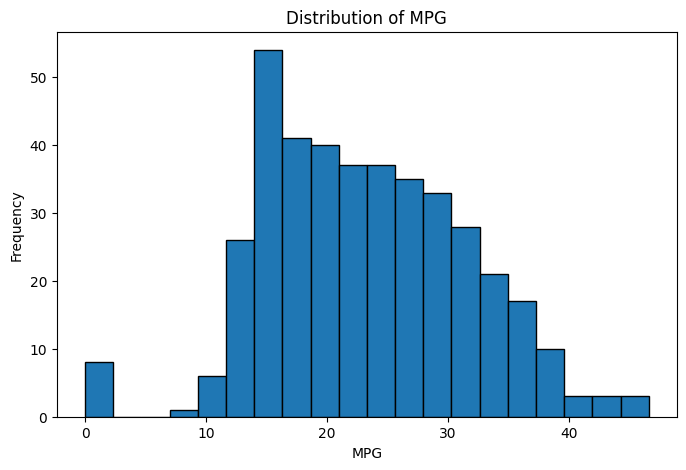

In [56]:
# Convert MPG to numeric
df_cars['MPG'] = pd.to_numeric(df_cars['MPG'], errors='coerce')

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(df_cars['MPG'].dropna(), bins=20, edgecolor='black')
plt.title('Distribution of MPG')
plt.xlabel('MPG')
plt.ylabel('Frequency')
plt.show()

The distribution is approximately normal, so we impute `MPG` missing values with the mean.

In [57]:
# Calculate mean
mpg_mean = df_cars['MPG'].mean()
print(f"Mean MPG: {mpg_mean:.2f}")

# Impute missing values
df_cars['MPG'] = df_cars['MPG'].fillna(mpg_mean)

# Verify
print("Missing Values in MPG:", df_cars['MPG'].isnull().sum())

Mean MPG: 23.10
Missing Values in MPG: 0


### Step 6: Use SimpleImputer

We apply `SimpleImputer` to all numerical columns for systematic imputation.

In [58]:
# Select numerical columns
numerical_cols = df_cars.select_dtypes(include=['float64', 'int64']).columns

# Initialize imputer
imputer = SimpleImputer(strategy='mean')

# Fit and transform
df_cars[numerical_cols] = imputer.fit_transform(df_cars[numerical_cols])

# Verify
print("Missing Values after Imputation:")
print(df_cars[numerical_cols].isnull().sum())

Missing Values after Imputation:
MPG    0
dtype: int64


## Outlier Detection (Diabetes Dataset)

This section explains outlier detection concepts and demonstrates methods like visualization, Z-Score, and IQR to identify and remove outliers.


### Step 1: Load the Dataset

Load the dataset and inspect its structure.

In [59]:
# Outlier Detection (Diabetes Dataset) - Step 1: Load the Dataset
df_diabetes = pd.read_csv('./data/diabetes.csv')
df_diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Visualizing Outliers

Used box plots to visualize potential outliers in the 'Glucose' column.


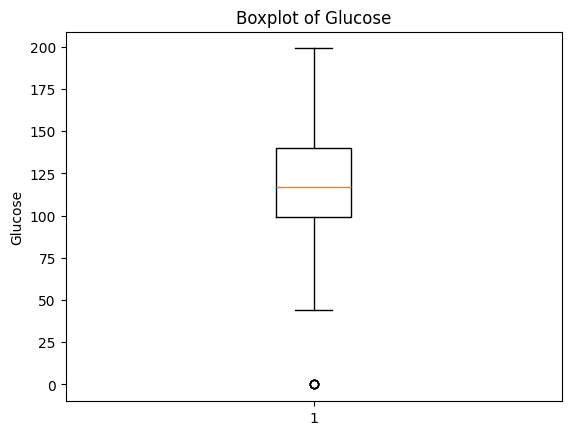

In [60]:
plt.boxplot(df_diabetes['Glucose'])
plt.title('Boxplot of Glucose')
plt.ylabel('Glucose')
plt.show()


### Visualize Outliers with Scatter Plot

Text(0.5, 1.0, 'Scatter Plot of Glucose vs. BMI')

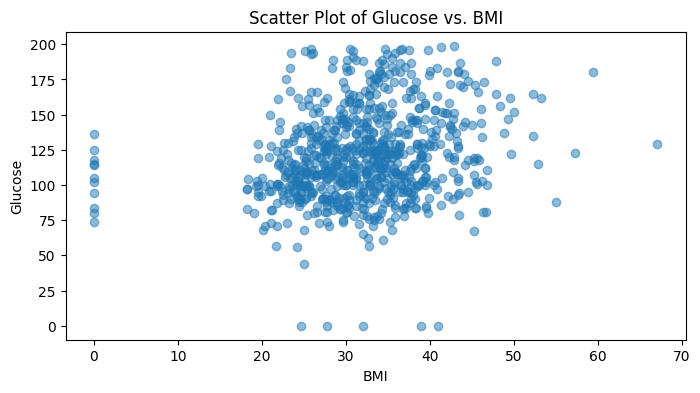

In [61]:
# Outlier Detection
plt.figure(figsize=(8, 4))
plt.scatter(df_diabetes['BMI'], df_diabetes['Glucose'], alpha=0.5)
plt.xlabel('BMI')
plt.ylabel('Glucose')
plt.title('Scatter Plot of Glucose vs. BMI')

### Z-Score Method

Calculating Z-scores and flag data points with |Z| > 3 as outliers.


In [62]:
df_diabetes['Glucose_z'] = zscore(df_diabetes['Glucose'])
outliers_z = df_diabetes[np.abs(df_diabetes['Glucose_z']) > 3]
print(f"Number of outliers (Z-Score): {len(outliers_z)}")

print("Outliers based on Z-Score (>3):")
print(tabulate(outliers_z, headers='keys', tablefmt='pipe', showindex=False))

Number of outliers (Z-Score): 5
Outliers based on Z-Score (>3):
|   Pregnancies |   Glucose |   BloodPressure |   SkinThickness |   Insulin |   BMI |   DiabetesPedigreeFunction |   Age |   Outcome |   Glucose_z |
|--------------:|----------:|----------------:|----------------:|----------:|------:|---------------------------:|------:|----------:|------------:|
|             1 |         0 |              48 |              20 |         0 |  24.7 |                      0.14  |    22 |         0 |    -3.78365 |
|             1 |         0 |              74 |              20 |        23 |  27.7 |                      0.299 |    21 |         0 |    -3.78365 |
|             1 |         0 |              68 |              35 |         0 |  32   |                      0.389 |    22 |         0 |    -3.78365 |
|             5 |         0 |              80 |              32 |         0 |  41   |                      0.346 |    37 |         1 |    -3.78365 |
|             6 |         0 |             

### IQR Method

Using the Inter-Quartile Range (IQR) to detect outliers.


In [63]:
Q1 = df_diabetes['Glucose'].quantile(0.25)
Q3 = df_diabetes['Glucose'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = df_diabetes[(df_diabetes['Glucose'] < lower_bound) | (df_diabetes['Glucose'] > upper_bound)]
print(f"Number of outliers (IQR): {len(outliers_iqr)}")

print("Outliers based on IQR:")
print(tabulate(outliers_iqr, headers='keys', tablefmt='pipe', showindex=False))

Number of outliers (IQR): 5
Outliers based on IQR:
|   Pregnancies |   Glucose |   BloodPressure |   SkinThickness |   Insulin |   BMI |   DiabetesPedigreeFunction |   Age |   Outcome |   Glucose_z |
|--------------:|----------:|----------------:|----------------:|----------:|------:|---------------------------:|------:|----------:|------------:|
|             1 |         0 |              48 |              20 |         0 |  24.7 |                      0.14  |    22 |         0 |    -3.78365 |
|             1 |         0 |              74 |              20 |        23 |  27.7 |                      0.299 |    21 |         0 |    -3.78365 |
|             1 |         0 |              68 |              35 |         0 |  32   |                      0.389 |    22 |         0 |    -3.78365 |
|             5 |         0 |              80 |              32 |         0 |  41   |                      0.346 |    37 |         1 |    -3.78365 |
|             6 |         0 |              68 |        

### Removing Outliers

Removing outliers based on the IQR method and compare dataset shapes before and after.


In [64]:
diabetes_clean = df_diabetes[(df_diabetes['Glucose'] >= lower_bound) & (df_diabetes['Glucose'] <= upper_bound)]
print("Before removing outliers:", df_diabetes.shape)
print("After removing outliers:", diabetes_clean.shape)

Before removing outliers: (768, 10)
After removing outliers: (763, 10)


## Conclusion

This lab gave me hands-on experience with some of the most important steps in data preprocessing. I started by learning how to tidy up messy datasets, using techniques like melting and string manipulation to get data into a format that’s much easier to analyze. Working with the Cars dataset, I identified columns with missing values and practiced different ways to handle them—sometimes dropping rows, and other times using imputation based on the data’s distribution.

Next, I tackled outlier detection using the Diabetes dataset. I visualized the data with box plots, calculated Z-scores, and used the IQR method to spot and deal with outliers. Each method helped me understand the impact of outliers and how they can affect analysis.

Throughout the lab, I made sure to document my steps clearly and used the `tabulate` library to make summary tables easy to read. I also followed good software engineering practices by freezing dependencies in a `requirements.txt` file, testing my notebook in a clean environment to ensure replicability, also added `.gitignore` for ingnoring env and using Git for version control.

Overall, this lab not only improved my technical skills in data cleaning and outlier detection, but also helped me get comfortable with professional coding habits that are essential for collaborative and reproducible data science work.
